# PDP assignment 4 - MLOps pipeline (AWS SageMaker)
*Adir Ben Ishay*

*667039*

*https://github.com/Adir667/INH-PDP*

# Import

In [1]:
# numpy as np
try:
    import numpy as np
    print('NumPy already installed, only imported')
except:
    !pip install numpy
    import numpy as np
    print('NumPy was not installed, installed and imported')
    
    # pandas as pd   
try:
    import pandas as pd
    print('pandas already installed, only imported')
except:
    !pip install pandas
    import pandas as pd
    print('pandas was not installed, installed and imported')    
    
    # pyplot as plt
try:
    import matplotlib.pyplot as plt
    print('PyPlot already installed, only imported')
except:
    !pip install matplotlib
    import matplotlib.pyplot as plt
    print('PyPlot was not installed, installed and imported')
    
    # sklearn
try:
    import sklean
    print('sklearn already installed, only imported')
except:
    !pip install sklearn
    print('sklearn was not installed, installed and imported')
    
    #seaboen as sns
try:
    import seaborn as sns
    print('Seaborn already installed, only imported')
except:
    !pip install seaborn
    import seaborn as sns
    print('Seaborn was not installed, installed and imported')  

NumPy already installed, only imported
pandas already installed, only imported
PyPlot already installed, only imported
sklearn was not installed, installed and imported
Seaborn already installed, only imported


# 1. The Data
We are going to use the datafile powerlifting.csv. This contains data from the OpenPowerlifting database as of April 2019. Powerlifting is a sport in which competitors compete to lift the most weight for their class in three separate barbell lifts: the Squat, Bench, and Deadlift.

## 1.1 Overview

Source: https://www.kaggle.com/datasets/kukuroo3/powerlifting-benchpress-weight-predict

In [2]:
# enter the code to load the data
lifting_df = pd.read_csv('data/powerLifting.csv', sep = ',', low_memory=False)

Here's a quick look at the data:

In [3]:
num_rows = lifting_df.shape[0]
print("Number of rows in the dataframe:", num_rows)

Number of rows in the dataframe: 11100


In [4]:
# enter the code to see the first few rows of the data
lifting_df.head()

,playerId,Name,Sex,Equipment,Age,BodyweightKg,BestSquatKg,BestDeadliftKg
0,2308.0,Peter Neeves,M,Wraps,30.0,89.81,179.17,192.78
1,22404.0,Josh Padilla,M,Raw,27.0,74.95,125.00,165.00
2,23397.0,Luke Dreier,M,Wraps,30.0,122.61,290.00,317.50
3,25058.0,Jacob New,M,Raw,20.0,88.00,187.50,240.00
4,2664.0,Jesse Burdick,M,Wraps,30.0,122.00,235.01,275.01


The dataset contains the playerId, name, gender, type of equipment used, the competitor body wieght and the results of the best squat and deadlift (in kg). we will try to classify the gender of the competitor by their best squat and deadlift

The categorical dependent variable "Sex" has the following categories:

In [5]:
gender_values = lifting_df['Sex'].unique()
print(gender_values)

['M' 'F']


## 1.2 Cleaining

In [6]:
#looking for nulls
print(lifting_df.isnull().sum())

playerId            0
Name                0
Sex                 0
Equipment           0
Age               245
BodyweightKg        0
BestSquatKg         0
BestDeadliftKg      0
dtype: int64


Age is not used for this classification, so we can leave it in

In [7]:
lifting_df.dtypes

playerId          float64
Name               object
Sex                object
Equipment          object
Age               float64
BodyweightKg      float64
BestSquatKg       float64
BestDeadliftKg    float64
dtype: object

lets correct this, and remove the irrelevant column for this classification scenario

In [8]:

lifting_df['Sex']=lifting_df['Sex'].astype('category')
lifting_df['BestSquatKg'] = lifting_df['BestSquatKg'].astype('float64')

#these are not relevant for this paper analysis
lifting_df.drop(['playerId', 'Name', 'Equipment', 'Age', 'BodyweightKg'], axis=1, inplace=True)

In [9]:
# Remove negative values from 'BestSquatKg' and 'BestDeadliftKg' columns
lifting_df[['BestSquatKg', 'BestDeadliftKg']] = lifting_df[['BestSquatKg', 'BestDeadliftKg']].apply(lambda x: x.where(x >= 0))

# Print the updated DataFrame
print(lifting_df[['BestSquatKg', 'BestDeadliftKg']])

       BestSquatKg  BestDeadliftKg
0           179.17          192.78
1           125.00          165.00
2           290.00          317.50
3           187.50          240.00
4           235.01          275.01
...            ...             ...
11095       270.00          315.00
11096        92.50          137.50
11097       250.00          311.00
11098       105.00          152.50
11099       105.00          145.00

[11100 rows x 2 columns]


In [10]:
lifting_df.dtypes

Sex               category
BestSquatKg        float64
BestDeadliftKg     float64
dtype: object

In [11]:
lifting_df.head()

,Sex,BestSquatKg,BestDeadliftKg
0,M,179.17,192.78
1,M,125.00,165.00
2,M,290.00,317.50
3,M,187.50,240.00
4,M,235.01,275.01


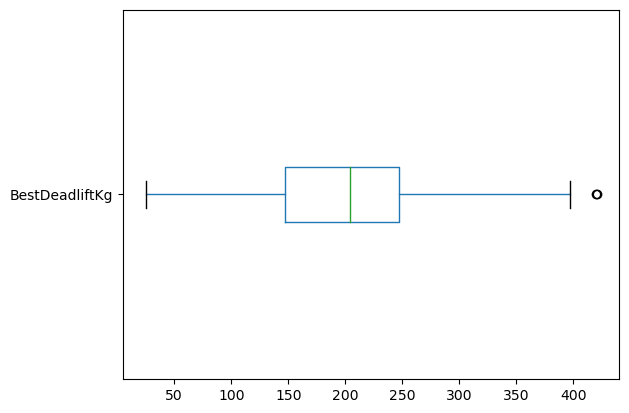

In [12]:
lifting_df.boxplot('BestDeadliftKg', grid = False, vert = False)
plt.show()

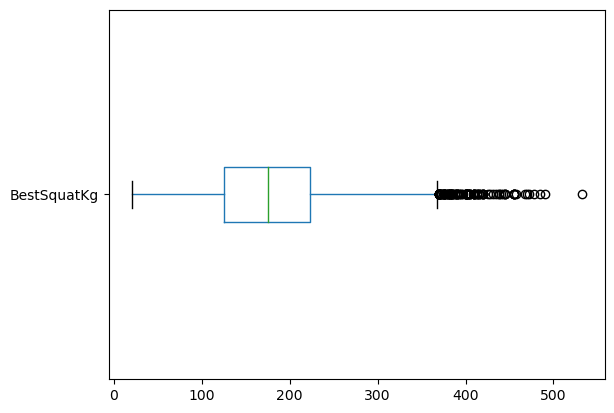

In [13]:
lifting_df.boxplot('BestSquatKg', grid = False, vert = False)
plt.show()

# 2. Classification Models

Model selection and baseline explore

In [14]:
# code to split data in training and testing
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X = lifting_df[['BestSquatKg', 'BestDeadliftKg']] # Feature variables
y = lifting_df['Sex'] # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 2.1 Baseline

All set, lets try to predict this using our independent variables BestSquatKg, BestDeadliftKg

Before we look at some 'real' models, its a good idea to get a baseline in by using one or more of the dummy classifiers. Lets see how they perform:

In [15]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# Import the standardscaler package
from sklearn.preprocessing import StandardScaler

gender = {"M":1, "F":0}
labels = gender.keys()
k = len(labels)

# set the scaler
scaler = StandardScaler()
scaler.fit(X_train)

# Convert the train and test X values, using the same scaler (so based on the X_train)
X_trainScaled = scaler.transform(X_train)
X_testScaled = scaler.transform(X_test)

**Dummy Classifier - Most Frequent** <br>
Sometimes referred to as ZeroR classification.

accuracy score: 0.6774774774774774


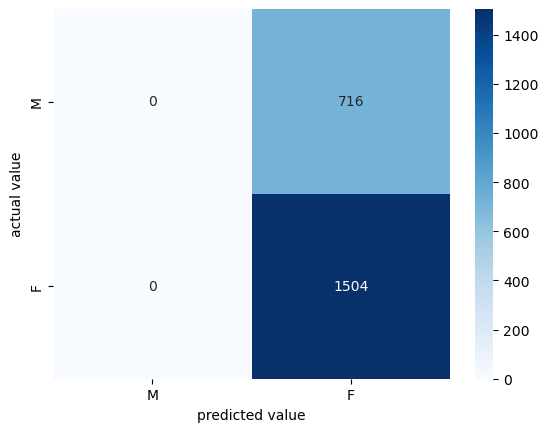

In [16]:
from sklearn.dummy import DummyClassifier

dumMF = DummyClassifier(strategy='most_frequent')
dumMF = dumMF.fit(X_trainScaled, y_train)
y_pred = dumMF.predict(X_testScaled)
print('accuracy score:', metrics.accuracy_score(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='g')
plt.xlabel('predicted value')
plt.ylabel('actual value')
plt.xticks(np.arange(k)+1/k, labels)
plt.yticks(np.arange(k)+1/k, labels)
plt.show()

Our baseline "dummy" model score is around 0.67

## 2.2 Classification models

**Naive Bayes**

Naive Bayes is a type of classification algorithm that is based on Bayes' theorem. It assumes that the presence or absence of a particular feature is independent of the presence or absence of any other feature. The algorithm uses this assumption to calculate the probability of a particular class given a set of features, and then selects the class with the highest probability as the predicted class for a given input. In other words, it calculates the probability of each class given the input data, and selects the class with the highest probability as the predicted class.

Lets create and fit this model:

In [17]:
# code to create the model, and fit the data.
lifting_df['Sex'].cat.codes

0        1
1        1
2        1
3        1
4        1
        ..
11095    1
11096    0
11097    1
11098    0
11099    0
Length: 11100, dtype: int8

In [18]:
X = lifting_df[['BestSquatKg', 'BestDeadliftKg']]
y = lifting_df['Sex']

In [19]:
from sklearn.naive_bayes import CategoricalNB

Now to measure its performance:

accuracy score: 0.8883783783783784


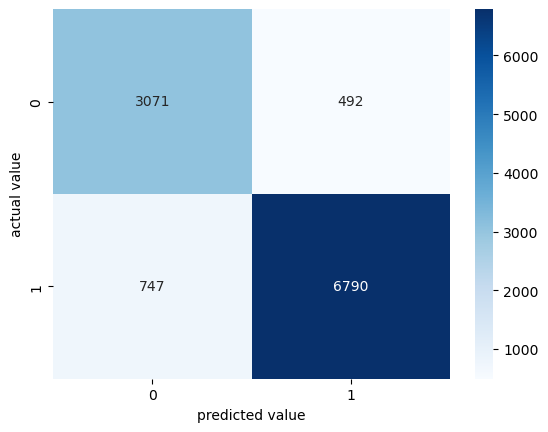

In [20]:
# code to show its accuracy score AND confusion matrix.
catNB = CategoricalNB()
catNB.fit(X, y)

y_pred = catNB.predict(X)

print('accuracy score:', metrics.accuracy_score(y, y_pred))
# The confusion matrix

sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap='Blues', fmt='g')
plt.xlabel('predicted value')
plt.ylabel('actual value')
plt.show()

## 2.3 Prediction

In [26]:
# code to show the prediction
genderTest=[82, 101] # BestSquatKg, BestDeadliftKg
genderTest=np.array(genderTest)
genderTest = genderTest.reshape(1, -1)
print(catNB.predict(genderTest))

['F']


C:\Users\adir7\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but CategoricalNB was fitted with feature names
  warnings.warn(


In [27]:
probabilities = catNB.predict_proba(genderTest)
print('Class probabilities:', probabilities)

Class probabilities: [[0.92868896 0.07131104]]


C:\Users\adir7\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but CategoricalNB was fitted with feature names
  warnings.warn(


# 3. Pipeline

In [42]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score

# Load the data
lifting_df = pd.read_csv('data/powerlifting.csv', sep = ',', low_memory=False)

# fix
lifting_df['Sex'] = lifting_df['Sex'].astype('category')
lifting_df['BestSquatKg'] = lifting_df['BestSquatKg'].astype('float64')
lifting_df['BestDeadliftKg'] = lifting_df['BestDeadliftKg'].astype('float64')

#these are not relevant for this paper analysis
lifting_df.drop(['playerId', 'Name', 'Equipment', 'Age', 'BodyweightKg'], axis=1, inplace=True)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the pipeline by combining the preprocessing steps with the classification model
pipeline = Pipeline(steps=[
    ('classifier', CategoricalNB())
])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Evaluate the model on the test data
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.8900900900900901
